# Customer Churn Project — Part 2: Explonatory Data Analysis

This notebook is the starting point for the Customer Churn Analysis Project. Its primary goals are to ingest, explore, clean, and augment the customer activity logs to build a robust dataset for understanding user behavior and churn.

Specifically, in this notebook, I:

1. Load the raw  Customer Interaction Log Data (JSON format) into a Spark DataFrame.
2. Explore and inspect the data schema and content.
3. Engineer a churn label, date and prtiod columns, location columns for each user by identifying cancellation events.
5. Validate the processed dataset to ensure it is ready for downstream exploratory data analysis (see [02_EDA.ipynb](02_EDA.ipynb)).

The focus here is on data integrity, reproducibility, and preparing a clean analytical foundation for modeling customer retention and churn in later stages of the project.

In [ ]:
import json
import pandas as pd
import numpy as np
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd



sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [ ]:
import os
from pyspark.sql import SparkSession

os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home"

try:
    spark.stop()
except:
    pass

# Build Spark
spark = (
    SparkSession.builder
    .appName("CustomerChurn_EDA")
    .master("local[*]")
    .config("spark.driver.memory", "6g")   # use "8g" if you have ≥16 GB RAM
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/13 14:13:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/13 14:13:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/13 14:13:08 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### I. Data Loading

In [7]:
data = spark.read.parquet("../data/cleaned_churn_data.parquet")

The dataset contains detailed user activity logs from a digital music streaming service.
Each record represents a user interaction — such as playing a song, giving a thumbs-up, or canceling a subscription — and includes demographic, behavioral, and technical information.
The data spans over different events and covers attributes like user identifiers, session details, song information, access methods, timestamps, and locations.
Additional engineered features (state, city, datetime, month, year) support time- and location-based analysis, while the churn_flag column labels users who have canceled their subscriptions, enabling churn prediction and retention analysis.

In [ ]:
data.printSchema()
data.show(5)

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn_flag: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- date: date (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)

+-------+--------------+---------+------

26259199

### II. Basic sanity checks

#### 1. Quick Data Check

The dataset includes 22,278 unique users who generated around 228,713 sessions and performed 22 different types of actions within the application.
In total, it contains over 26 million event records, providing a comprehensive view of user behavior and engagement across the platform.

In [23]:
# number of unique users
num_users = data.select("userId").distinct().count()
print(f"Number of unique users: {num_users}")

# number of unique sessions
num_sessions = data.select("sessionId").distinct().count()
print(f"Number of unique sessions: {num_sessions}")

# number of unique events (what users can do in App and with App)
num_unique_events = data.select("page").distinct().count()
print(f"Number of unique events: {num_unique_events}")

# total number of events = rows
num_events = data.count()
print(f"Total number of events (records): {num_events}")

Number of unique users: 22278
Number of unique sessions: 228713
Number of unique events: 22
Total number of events (records): 26259199


In [35]:
data.createOrReplaceTempView("user_data")

In [36]:
spark.sql("""
    SELECT *
    FROM user_data
    WHERE userId == 1994878
""").show(truncate=False)

+-------+----------------------------------------------------------------------+---------+---------+------+-------------+--------+---------+-----+----------------------------+------+----------+-------------+---------+-------------------------------------------------------------------+------+-------------+-----------------------------------------------------------------------------------------------------------------------+----------+-----+------------------------+-------------------+----------+-----+----+
|userId |artist                                                                |auth     |firstName|gender|itemInSession|lastName|length   |level|location                    |method|page      |registration |sessionId|song                                                               |status|ts           |userAgent                                                                                                              |churn_flag|state|city                    |datetime           |d

The chart below shows the distribution of user actions recorded in the dataset.
The “NextSong” event dominates the activity log, indicating that most user interactions involve playing music tracks.
Other common events, such as Home, Thumbs Up, Add to Playlist, and Roll Advert, appear far less frequently.
Less frequent actions — including Cancel, Cancellation Confirmation, and Logout — provide key behavioral signals for identifying users likely to churn.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


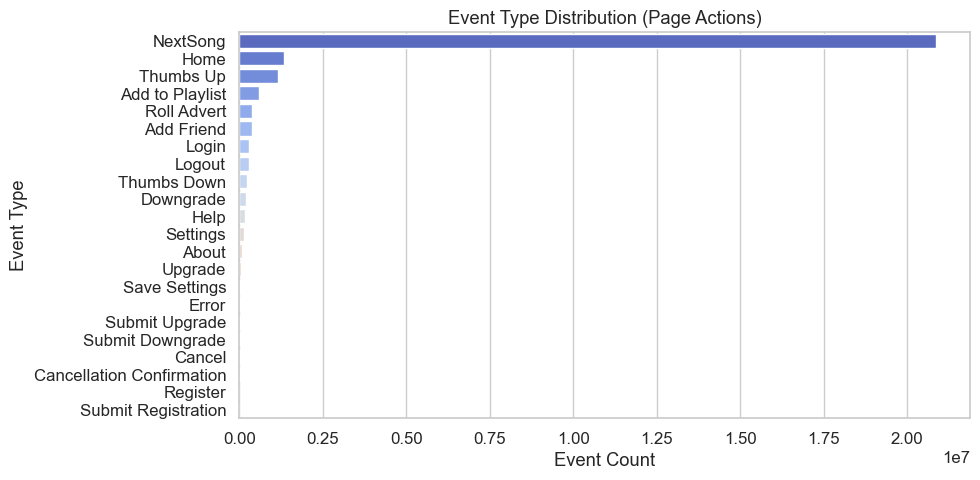

In [ ]:
event_counts = (
    data.groupBy("page")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

plt.figure(figsize=(10,5))
sns.barplot(data=event_counts, x="count", y="page", palette="coolwarm", hue="page", legend=False)
plt.title("Event Type Distribution (Page Actions)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

### II. Missing values overview

The missing value analysis reveals that several columns contain null or empty entries, particularly those related to user demographics and activity details such as artist, firstName, lastName, location, and userAgent. Columns like userId, page, sessionId, and ts are mostly complete, ensuring that key behavioral data remains reliable for downstream analysis.



So far, I can say that missing (NA) `registration` values could be a potential problem.

Variables such as:

`artist`, `song`, and `length` – may be missing for non-music events (e.g., login, logout), which is expected and acceptable;

`firstName`, `lastName`, and `gender` – demographic gaps are common for anonymous or guest users;

`location`, `state`, and `city` – may be missing if userAgent data lacks geolocation information; this is acceptable for most sessions;

`userAgent` – can be null for backend or system-generated events and is not essential for churn modeling.


I will conduct a more detailed analysis of missing values later in this notebook to better understand their patterns, potential causes, and impact on model performance.

In [24]:
data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data.columns]).show(truncate=False)

+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+--------+----+-----+----+
|userId|artist |auth|firstName|gender|itemInSession|lastName|length |level|location|method|page|registration|sessionId|song   |status|ts |userAgent|churn_flag|state |city  |datetime|date|month|year|
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+--------+----+-----+----+
|0     |5408927|0   |778479   |778479|0            |778479  |5408927|0    |778479  |0     |0   |778479      |0        |5408927|0     |0  |778479   |0         |778479|778479|0       |0   |0    |0   |
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+--------+----+-----+----+



Overall, there are 22 unique user activities:

In [44]:
unique_pages = data.select("page").distinct().toPandas()["page"].unique()
print("Unique page variables ({}):\n{}".format(len(unique_pages), unique_pages))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Unique page variables (22):
['Home' 'Settings' 'Error' 'Submit Upgrade' 'About' 'Cancel' 'NextSong'
 'Thumbs Up' 'Help' 'Logout' 'Submit Downgrade' 'Login'
 'Submit Registration' 'Downgrade' 'Save Settings' 'Register'
 'Add to Playlist' 'Cancellation Confirmation' 'Add Friend' 'Thumbs Down'
 'Roll Advert' 'Upgrade']


In [33]:
spark.sql("""
    SELECT *
    FROM user_data
    WHERE gender IS NULL
""").show(truncate=False)

+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+-------------------+----------+-----+----+
|userId |artist|auth      |firstName|gender|itemInSession|lastName|length|level|location|method|page |registration|sessionId|song|status|ts           |userAgent|churn_flag|state|city|datetime           |date      |month|year|
+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+-------------------+----------+-----+----+
|1261737|NULL  |Logged Out|NULL     |NULL  |200          |NULL    |NULL  |paid |NULL    |GET   |About|NULL        |44007    |NULL|200   |1539108795000|NULL     |0         |NULL |NULL|2018-10-09 11:13:15|2018-10-09|10   |2018|
|1261737|NULL  |Logged Out|NULL     |NULL  |189          |NULL    |NULL  |free |NULL    |GET   |

All user activities where gender (and likely first/last names and location) are NULL:

In [45]:
spark.sql("""
    SELECT distinct page
    FROM user_data
    WHERE gender IS NULL
""").show(truncate=False)

+-------------------+
|page               |
+-------------------+
|About              |
|Home               |
|Error              |
|Login              |
|Help               |
|Submit Registration|
|Register           |
+-------------------+



In [30]:
data.filter(F.col("gender").isNull()).show(truncate=False)

+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+-------------------+----------+-----+----+
|userId |artist|auth      |firstName|gender|itemInSession|lastName|length|level|location|method|page |registration|sessionId|song|status|ts           |userAgent|churn_flag|state|city|datetime           |date      |month|year|
+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+-------------------+----------+-----+----+
|1261737|NULL  |Logged Out|NULL     |NULL  |200          |NULL    |NULL  |paid |NULL    |GET   |About|NULL        |44007    |NULL|200   |1539108795000|NULL     |0         |NULL |NULL|2018-10-09 11:13:15|2018-10-09|10   |2018|
|1261737|NULL  |Logged Out|NULL     |NULL  |189          |NULL    |NULL  |free |NULL    |GET   |

A quick check whether my hypothesis is correct:

In [46]:
spark.sql("""
    SELECT userId, page, gender, firstName, lastName, location
    FROM user_data
    WHERE
        (gender IS NULL OR firstName IS NULL OR lastName IS NULL OR location IS NULL)
        AND page NOT IN (
            SELECT DISTINCT page
            FROM user_data
            WHERE gender IS NULL
        )
""").show(truncate=False)

+------+----+------+---------+--------+--------+
|userId|page|gender|firstName|lastName|location|
+------+----+------+---------+--------+--------+
+------+----+------+---------+--------+--------+



All null values in user demographic or location fields occur only on pages (like Login, Register, Cancel, etc.) where missing user data is expected. So my dataset is logically consistent, and I don’t have unexpected missing data in user-related columns.


### III.  Churn Rate Analysis

In [27]:
data.select("userId", "churn_flag").distinct().groupBy("churn_flag").count().show()

+----------+-----+
|churn_flag|count|
+----------+-----+
|         1| 5003|
|         0|17275|
+----------+-----+



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


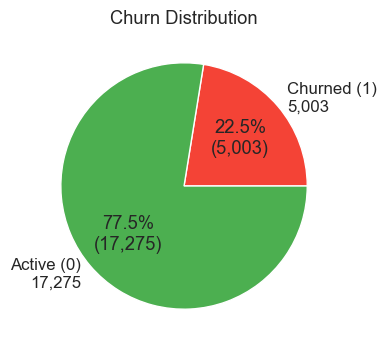

In [28]:
churn_counts = (
    data.select("userId", "churn_flag").distinct()
    .groupBy("churn_flag").count()
    .orderBy(F.desc("churn_flag"))
    .toPandas()
)
counts = churn_counts["count"]
labels = [f'Churned (1)\n{counts.iloc[0]:,}', f'Active (0)\n{counts.iloc[1]:,}']

plt.figure(figsize=(4,4))
plt.pie(
    counts, 
    labels=labels, 
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*counts.sum())):,})", 
    colors=["#F44336", "#4CAF50"]
)
plt.title("Churn Distribution")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


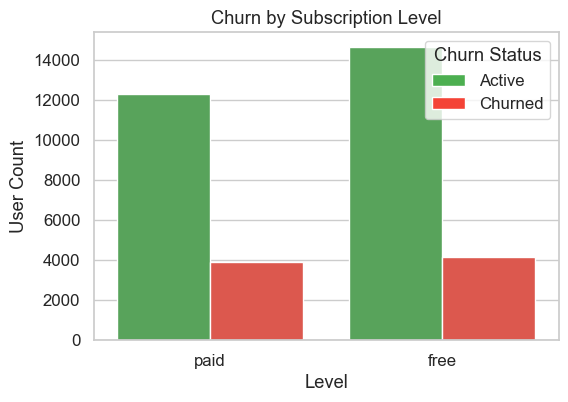

In [10]:
level_churn = (
    data.select("userId", "level", "churn_flag").distinct()
        .groupBy("level", "churn_flag").count()
        .toPandas()
)

plt.figure(figsize=(6,4))
sns.barplot(data=level_churn, x="level", y="count", hue="churn_flag", palette=["#4CAF50", "#F44336"])
plt.title("Churn by Subscription Level")
plt.xlabel("Level")
plt.ylabel("User Count")


legend_colors = ["#4CAF50", "#F44336"]
legend_labels = ["Active", "Churned"]
handles = [Patch(facecolor=c, label=l) for c, l in zip(legend_colors, legend_labels)]
plt.legend(handles=handles, title="Churn Status")
plt.show()

### IV. Gender & Level Distribution

In [11]:
data.select("userId", "gender", "level", "churn_flag").distinct().groupBy("gender", "churn_flag").count().show()
data.select("userId", "level", "churn_flag").distinct().groupBy("level", "churn_flag").count().show()

+------+----------+-----+
|gender|churn_flag|count|
+------+----------+-----+
|     M|         1| 4285|
|     F|         0|12887|
|     M|         0|14051|
|     F|         1| 3753|
|  NULL|         0|    2|
+------+----------+-----+



+-----+----------+-----+
|level|churn_flag|count|
+-----+----------+-----+
| paid|         1| 3891|
| free|         0|14646|
| paid|         0|12294|
| free|         1| 4147|
+-----+----------+-----+



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_94175/2593587250.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


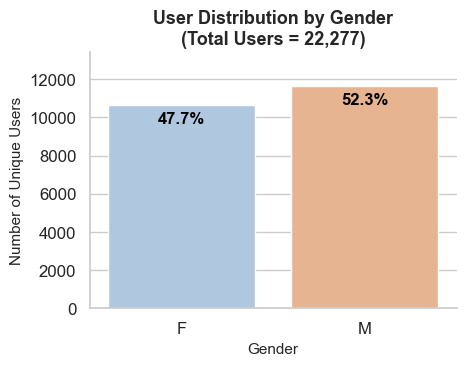

In [12]:
# --- Aggregate unique users by gender, EXCLUDING NULLS ---
gender_user_counts = (
    data
    .filter(F.col("gender").isNotNull())
    .select("userId", "gender")
    .distinct()
    .groupBy("gender")
    .count()
    .withColumnRenamed("count", "num_users")
    .toPandas()
)

# --- Compute percentages ---
total_users = gender_user_counts["num_users"].sum()
gender_user_counts["percent"] = (
    100 * gender_user_counts["num_users"] / total_users
).round(1)

# --- Sort alphabetically (F, M) ---
gender_user_counts = gender_user_counts.sort_values("gender").reset_index(drop=True)

# --- Plot ---
plt.figure(figsize=(5.2, 4.2))
ax = sns.barplot(
    data=gender_user_counts,
    x="gender", y="num_users",
    palette=["#A7C7E7", "#F4B183"]
)

# --- Add percentage labels inside bars (well-framed) ---
for i, row in gender_user_counts.iterrows():
    ax.text(
        i, row["num_users"] * 0.97,
        f'{row["percent"]:.1f}%',
        ha='center', va='top',
        fontsize=12, color='black', fontweight='semibold'
    )

# --- Style adjustments for professional framing ---
ax.set_ylim(0, gender_user_counts["num_users"].max() * 1.15)
sns.despine(left=False, bottom=False)
plt.title(
    f"User Distribution by Gender\n(Total Users = {total_users:,})",
    fontsize=13, weight='semibold'
)
plt.xlabel("Gender", fontsize=11)
plt.ylabel("Number of Unique Users", fontsize=11)
plt.tight_layout(pad=2)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


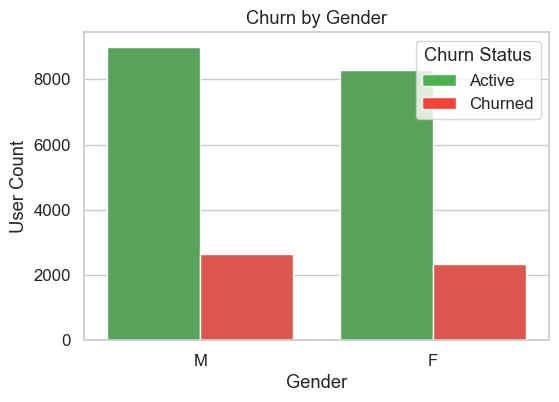

In [13]:
gender_churn = (
    data.select("userId", "gender", "churn_flag").distinct()
        .groupBy("gender", "churn_flag").count()
        .toPandas()
)

plt.figure(figsize=(6,4))
bar = sns.barplot(
    data=gender_churn, 
    x="gender", 
    y="count", 
    hue="churn_flag", 
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("Churn by Gender")
plt.xlabel("Gender")
plt.ylabel("User Count")
# Make custom legend matching color to 'Active' and 'Churned'
from matplotlib.patches import Patch
legend_colors = ["#4CAF50", "#F44336"]
legend_labels = ["Active", "Churned"]
handles = [Patch(facecolor=c, label=l) for c, l in zip(legend_colors, legend_labels)]
plt.legend(handles=handles, title="Churn Status")
plt.show()

### V. User activity intensity

In [14]:
activity = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("songs_played")
        )
)
activity.groupBy("churn_flag").agg(
    F.avg("num_sessions").alias("avg_sessions"),
    F.avg("songs_played").alias("avg_songs")
).show()

+----------+------------------+-----------------+
|churn_flag|      avg_sessions|        avg_songs|
+----------+------------------+-----------------+
|         1|12.300219868079152|876.7291625024985|
|         0|22.786685962373372|953.0533140376266|
+----------+------------------+-----------------+



### VI. Feature correlations (behavior vs churn)

In [15]:
from pyspark.sql.functions import avg

# Thumbs Up / Thumbs Down / Add to Playlist patterns
interactions = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("thumbs_up"),
            F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("thumbs_down"),
            F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("add_playlist")
        )
)
interactions.groupBy("churn_flag").agg(
    avg("thumbs_up").alias("avg_thumbs_up"),
    avg("thumbs_down").alias("avg_thumbs_down"),
    avg("add_playlist").alias("avg_add_playlist")
).show()

+----------+------------------+------------------+------------------+
|churn_flag|     avg_thumbs_up|   avg_thumbs_down|  avg_add_playlist|
+----------+------------------+------------------+------------------+
|         1|44.867479512292626|11.124525284829103| 24.91625024985009|
|         0| 53.66095513748191|10.625528219971056|27.395947901591896|
+----------+------------------+------------------+------------------+



### VII. Engagement duration

In [16]:
# Aggregate engagement features per user
engagement_df = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("num_songs"),
            F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("thumbs_up"),
            F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("thumbs_down"),
            F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("add_playlist"),
            (F.max("ts") - F.min("ts")).alias("active_span_ms")
        )
        .withColumn("active_days", (F.col("active_span_ms") / (1000 * 60 * 60 * 24)))
)

# Convert to pandas for visualization
engagement_pdf = engagement_df.toPandas()
engagement_pdf.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,userId,churn_flag,num_sessions,num_songs,thumbs_up,thumbs_down,add_playlist,active_span_ms,active_days
0,1567000,0,50,3712,202,37,113,5269838000,60.993495
1,1165912,0,120,9167,458,101,282,5217446000,60.387106
2,1495461,0,14,1785,95,18,49,5225003000,60.474572
3,1259098,1,14,965,40,14,30,3304395000,38.245312
4,1377317,0,40,4012,204,38,117,5135626000,59.440116


In [17]:
summary_stats = (
    engagement_pdf.groupby("churn_flag")
    [["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]]
    .mean()
    .round(2)
)
summary_stats

,num_sessions,num_songs,thumbs_up,thumbs_down,add_playlist,active_days
churn_flag,,,,,,
0,22.79,953.05,53.66,10.63,27.40,45.78
1,12.30,876.73,44.87,11.12,24.92,24.35


We can already see clear behavioral differences — churned users tend to have fewer sessions, fewer songs played, and shorter active periods.

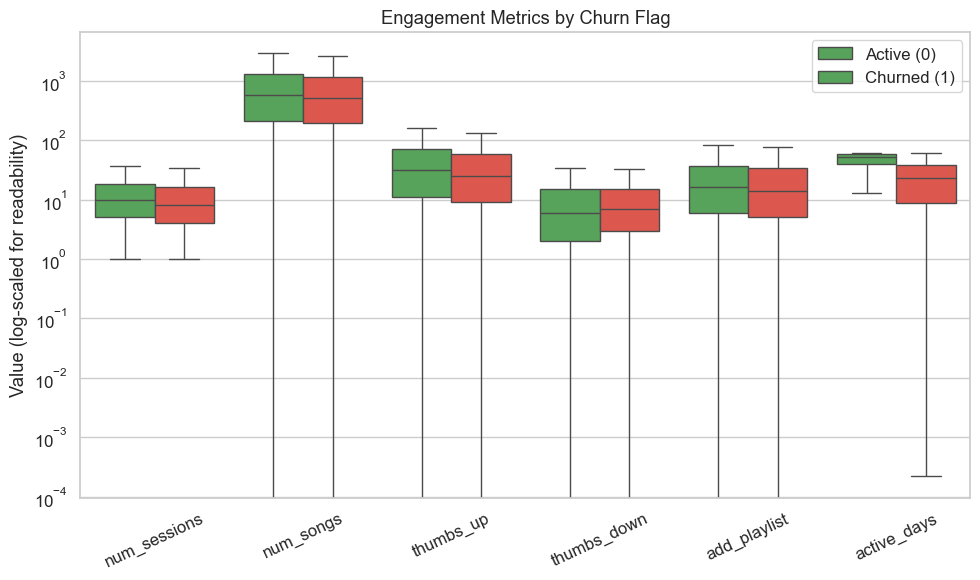

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10,6))

melted = engagement_pdf.melt(
    id_vars="churn_flag",
    value_vars=["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"],
    var_name="metric", value_name="value"
)

sns.boxplot(data=melted, x="metric", y="value", hue="churn_flag",
            palette={0: "#4CAF50", 1: "#F44336"}, showfliers=False)

plt.title("Engagement Metrics by Churn Flag")
plt.xlabel("")
plt.ylabel("Value (log-scaled for readability)")
plt.yscale("log")
plt.legend(["Active (0)", "Churned (1)"])
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### Insights:
- **Active users** show higher engagement across all dimensions: more sessions, more songs played, and longer activity spans.
- **Churned users** typically interact less and have fewer positive signals (likes, playlist additions).
- The number of **Thumbs Down** events is slightly higher relative to engagement among churners, suggesting dissatisfaction may contribute to churn.

In [18]:
# Correlation between engagement metrics and churn flag
corr = engagement_pdf.corr(numeric_only=True)["churn_flag"].sort_values(ascending=False)
corr

churn_flag        1.000000
thumbs_down       0.016506
num_sessions     -0.004131
num_songs        -0.028965
add_playlist     -0.032266
thumbs_up        -0.056815
active_span_ms   -0.473456
active_days      -0.473456
Name: churn_flag, dtype: float64

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_94175/3752608892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.index, y=corr.values, palette="coolwarm")


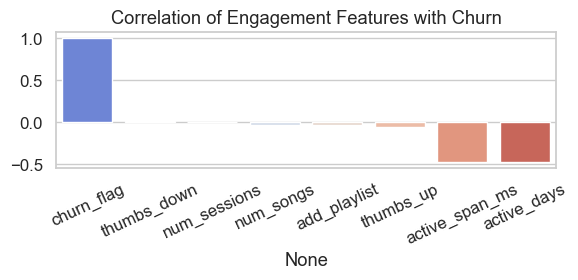

In [19]:
plt.figure(figsize=(6,3))
sns.barplot(x=corr.index, y=corr.values, palette="coolwarm")
plt.title("Correlation of Engagement Features with Churn")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### IX. Event Type Exploration

## 6️⃣ Event Type Exploration

In this section, we explore user interactions — represented by the `page` variable.  
Each event corresponds to a specific user action such as playing a song, giving a thumbs up, or canceling their subscription.

We’ll first examine which event types dominate overall, and then compare their distribution between **active** and **churned** users.

#### 1. Count events by type

In [20]:
# Count frequency of each event type
event_counts = (
    data.groupBy("page")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

event_counts

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,page,count
0,NextSong,20850272
1,Home,1343102
2,Thumbs Up,1151465
3,Add to Playlist,597921
4,Roll Advert,385212
5,Add Friend,381664
6,Login,296350
7,Logout,296005
8,Thumbs Down,239212
9,Downgrade,184240


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_94175/1539695542.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_counts.head(15), y="page", x="count", palette="coolwarm")


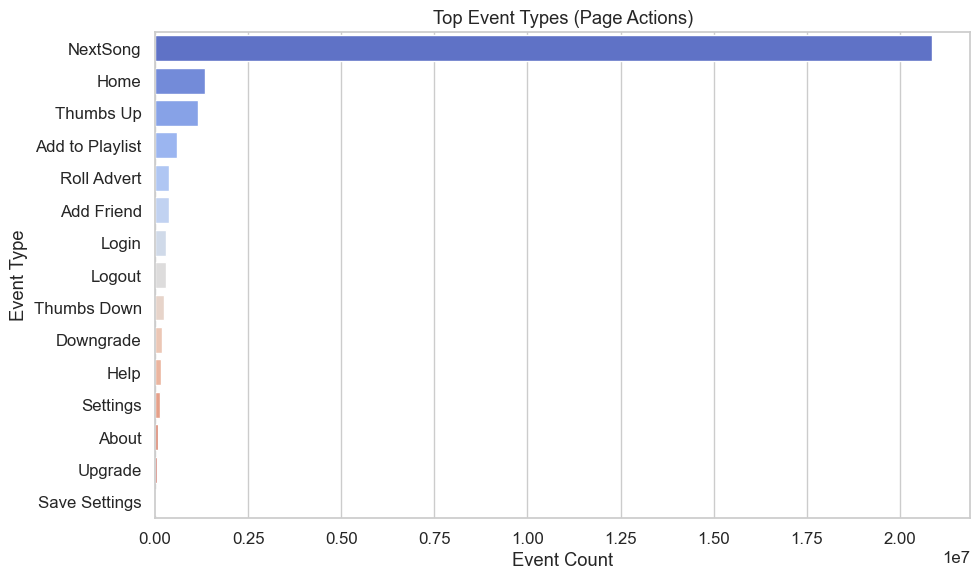

In [21]:
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10,6))
sns.barplot(data=event_counts.head(15), y="page", x="count", palette="coolwarm")

plt.title("Top Event Types (Page Actions)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

#### 2. Compare event patterns by churn status

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


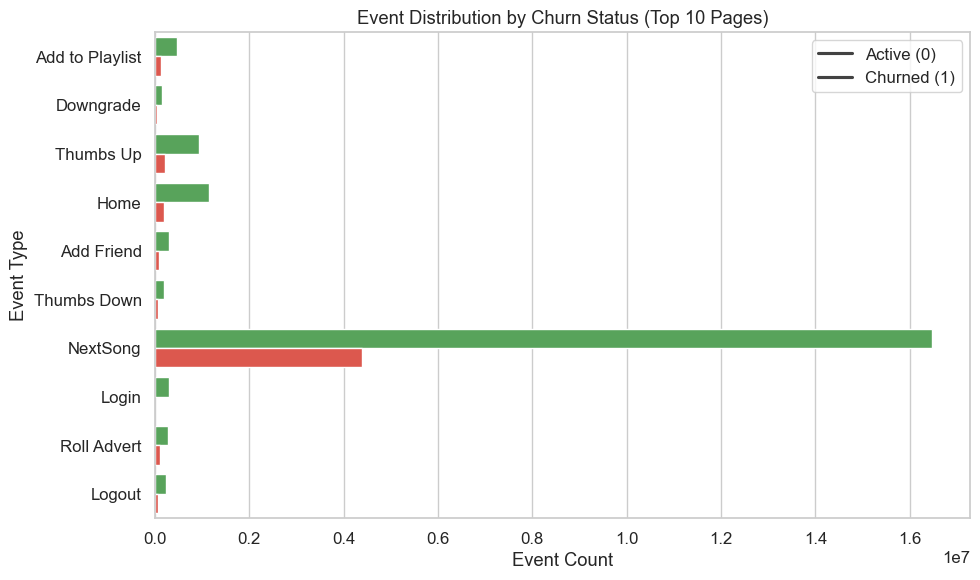

In [22]:
event_by_churn = (
    data.groupBy("page", "churn_flag")
        .count()
        .toPandas()
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=event_by_churn[event_by_churn["page"].isin(event_counts.head(10)["page"])],
    x="count", y="page", hue="churn_flag",
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("Event Distribution by Churn Status (Top 10 Pages)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.legend(["Active (0)", "Churned (1)"])
plt.tight_layout()
plt.show()

#### 3. Normalize event proportions

In [23]:
# Normalize counts per churn_flag
event_share = (
    data.groupBy("churn_flag", "page")
        .count()
        .groupBy("page")
        .pivot("churn_flag")
        .sum("count")
        .fillna(0)
        .toPandas()
)

# Ensure columns are strings for compatibility
event_share.columns = event_share.columns.astype(str)

# If 0 or 1 are missing as columns after pivot, add them with zeros
for col in ["0", "1"]:
    if col not in event_share.columns:
        event_share[col] = 0

event_share["total"] = event_share["0"] + event_share["1"]
# Avoid division by zero
event_share["share_churned"] = event_share["1"] / event_share["total"].replace(0, np.nan) * 100
event_share = event_share.sort_values("share_churned", ascending=False).reset_index(drop=True)

event_share.head(10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,page,0,1,total,share_churned
0,Cancellation Confirmation,0,5003,5003,100.000000
1,Cancel,0,5003,5003,100.000000
2,Roll Advert,284906,100306,385212,26.039168
3,Submit Upgrade,11448,3687,15135,24.360753
4,Downgrade,140816,43424,184240,23.569257
5,Thumbs Down,183556,55656,239212,23.266391
6,Submit Downgrade,4992,1502,6494,23.129042
7,Upgrade,39276,11231,50507,22.236522
8,Settings,115357,31717,147074,21.565334
9,Logout,233305,62700,296005,21.182075


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_94175/682584469.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_share.head(10), x="share_churned", y="page", palette="Reds_r")


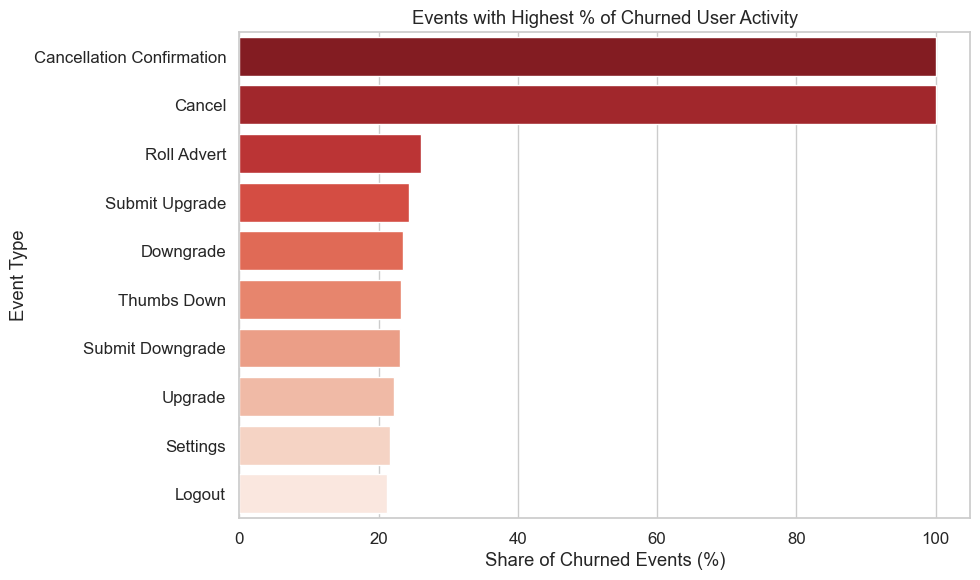

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(data=event_share.head(10), x="share_churned", y="page", palette="Reds_r")
plt.title("Events with Highest % of Churned User Activity")
plt.xlabel("Share of Churned Events (%)")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

### 🟥 Understanding the Difference: `Cancel` vs `Cancellation Confirmation`

In the dataset, the **`page`** column records every user action (event) on the platform.  
Two of these events — `Cancel` and `Cancellation Confirmation` — are closely related but have very different meanings:

| Page Event | Description | Indicates |
|-------------|-------------|------------|
| **Cancel** | The user *clicked on the "Cancel" button* to start the cancellation process. Some users may explore this option without actually completing it. | 🟡 *Intent to churn* (not a confirmed cancellation) |
| **Cancellation Confirmation** | The user *confirmed their cancellation* — meaning they officially unsubscribed and stopped using the service. | 🔴 *Actual churn* |

Therefore, in churn labeling we consider **only users who reached `Cancellation Confirmation` as churned**.  
This ensures that we capture **real customer attrition**, not just users exploring cancellation options.

> 💡 *Optional extension:* Users who clicked on `Cancel` but did not confirm can be analyzed as an *“at-risk”* group — those showing churn intent but still retained.

In [25]:
# How many users clicked "Cancel" but did NOT confirm ("at-risk" users)?

# Get all users who clicked "Cancel"
users_cancel = data.filter(data.page == "Cancel").select("userId").distinct()

# Get all users who had "Cancellation Confirmation"
users_canceled = data.filter(data.page == "Cancellation Confirmation").select("userId").distinct()

# "At-risk" users: those who clicked "Cancel" but not "Cancellation Confirmation"
users_at_risk = users_cancel.subtract(users_canceled)

num_at_risk = users_at_risk.count()
print(f"Number of users who clicked 'Cancel' but did not confirm (at-risk): {num_at_risk}")

Number of users who clicked 'Cancel' but did not confirm (at-risk): 0


### Monthly Churn and Activity Trends

In [46]:
# Show all unique months present in the dataset
months = (
    data.withColumn(
        "event_month",
        F.date_trunc("month", F.from_unixtime(F.col("ts") / 1000))
    )
    .select("event_month")
    .distinct()
    .orderBy("event_month")
)

months_pd = months.toPandas()
print("All months in dataset:")
print(months_pd)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


All months in dataset:
  event_month
0  2018-09-01
1  2018-10-01
2  2018-11-01


25/10/13 08:58:04 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1045257 ms exceeds timeout 120000 ms
25/10/13 08:58:04 WARN SparkContext: Killing executors is not supported by current scheduler.
25/10/13 08:58:11 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:669)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1296)
	at 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


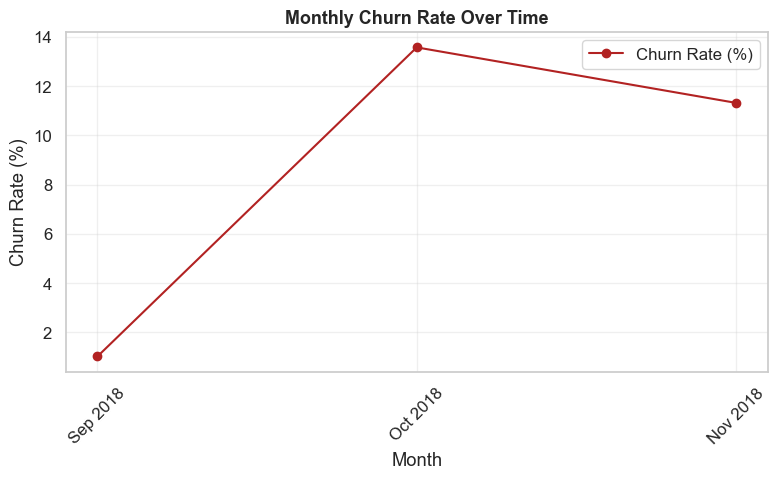

In [ ]:
# 🕒 Add month column based on event timestamp
data_month = data.withColumn(
    "event_month",
    F.date_trunc("month", F.from_unixtime(F.col("ts") / 1000))
)

# 📈 Monthly active users
active_month = (
    data_month
    .filter(F.col("userId").isNotNull() & (F.col("userId") != ""))
    .select("userId", "event_month")
    .distinct()
    .groupBy("event_month")
    .agg(F.countDistinct("userId").alias("active_users"))
)

# 💔 Monthly churned users
churn_month = (
    data_month
    .filter(F.col("page") == "Cancellation Confirmation")
    .select("userId", "event_month")
    .distinct()
    .groupBy("event_month")
    .agg(F.countDistinct("userId").alias("churned_users"))
)

# 🔗 Join + calculate churn rate
trend = (
    active_month.join(churn_month, on="event_month", how="left")
    .fillna({"churned_users": 0})
    .withColumn("churn_rate", F.col("churned_users") / F.col("active_users"))
    .orderBy("event_month")
)

# 🪶 Convert to Pandas for plotting
trend_pd = trend.toPandas()

# 🗓️ Format month name for readability
trend_pd["month_name"] = pd.to_datetime(trend_pd["event_month"]).dt.strftime("%b %Y")

# 📊 Plot
plt.figure(figsize=(8,5))
plt.plot(trend_pd["month_name"], trend_pd["churn_rate"]*100, marker='o', color="firebrick", label="Churn Rate (%)")
plt.title("Monthly Churn Rate Over Time", fontsize=13, weight="semibold")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### X. Correlations (Feature vs Churn)

To understand which user behaviors are most strongly associated with churn,  
we examine correlations between engagement features (sessions, songs, likes, etc.) and the churn flag.

This helps identify which features are likely to be **predictive** and will inform our modeling phase.

In [26]:
engagement_pdf = engagement_df.toPandas()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [27]:
engagement_df = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("num_songs"),
            F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("thumbs_up"),
            F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("thumbs_down"),
            F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("add_playlist"),
            (F.max("ts") - F.min("ts")).alias("active_span_ms")
        )
        .withColumn("active_days", (F.col("active_span_ms") / (1000 * 60 * 60 * 24)))
)
engagement_pdf = engagement_df.toPandas()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [28]:
corr = engagement_pdf.corr(numeric_only=True).round(3)
corr["churn_flag"].sort_values(ascending=False)

churn_flag        1.000
thumbs_down       0.017
num_sessions     -0.004
num_songs        -0.029
add_playlist     -0.032
thumbs_up        -0.057
active_span_ms   -0.473
active_days      -0.473
Name: churn_flag, dtype: float64

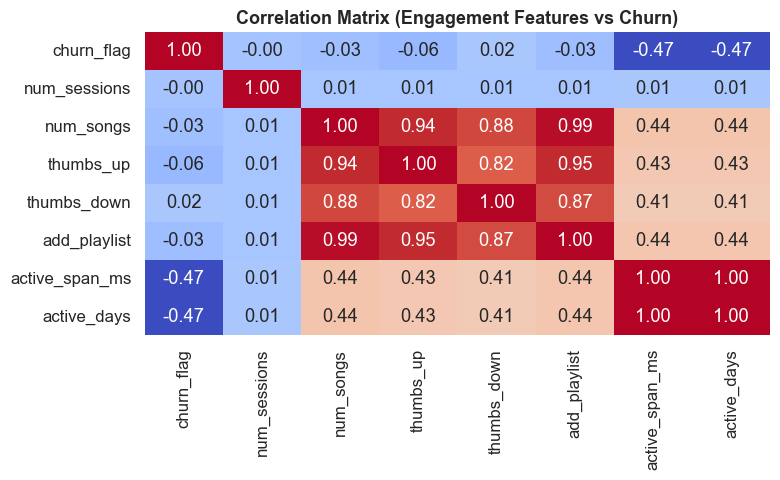

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.1)
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=False)
plt.title("Correlation Matrix (Engagement Features vs Churn)", fontsize=13, weight="semibold")
plt.tight_layout()
plt.show()

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_94175/3406003012.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_corr.values, y=churn_corr.index, palette="coolwarm")


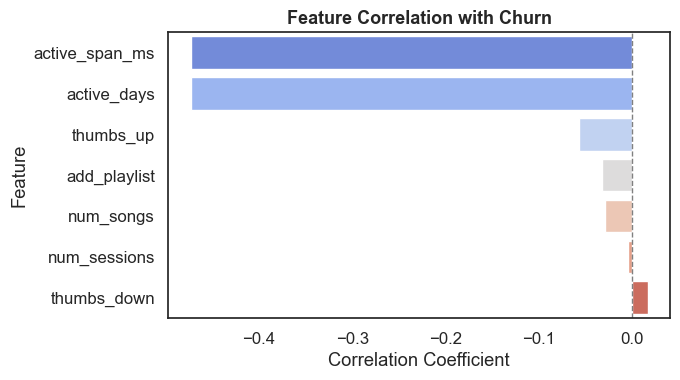

In [30]:
churn_corr = corr["churn_flag"].drop("churn_flag").sort_values()
plt.figure(figsize=(7,4))
sns.barplot(x=churn_corr.values, y=churn_corr.index, palette="coolwarm")
plt.title("Feature Correlation with Churn", fontsize=13, weight="semibold")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.axvline(0, color="gray", linestyle="--", lw=1)
plt.tight_layout()
plt.show()

### Insights:
- Features like **number of sessions**, **songs played**, and **active days** are **negatively correlated** with churn,  
  meaning that higher engagement corresponds to lower churn risk.
- **Thumbs Down** may show a slight **positive correlation** with churn, reflecting user dissatisfaction.
- These correlations confirm the intuition that **engagement intensity** is a key factor in retention.
- We'll use these variables as candidate predictors in our churn model.

### X. User Agent Analysis

In [31]:
data.select("userAgent").distinct().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                                |
+-----------------------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/6.1.5 Safari/537.77.4"                  |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"               |
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                          |
|"Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"       |
|Mozilla/5.0 (Window

### XI. Geographic Insights

The `location` field combines city and state information (e.g., *"San Francisco-Oakland-Hayward, CA"*).  
In this section, we analyze churn patterns by location to see whether certain regions have higher churn or engagement levels.

While geographic data is often only a proxy (e.g., time zones, demographics, or marketing coverage),  
it can still provide valuable insights for targeted retention strategies.

In [32]:
# Check top states
state_counts = (
    data.filter(F.col("state").isNotNull())
        .select("userId", "state")
        .distinct()
        .groupBy("state")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

state_counts.head(10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,state,count
0,CA,2804
1,TX,1815
2,NY-NJ-PA,1570
3,FL,1423
4,OH,703
5,IL-IN-WI,682
6,MI,670
7,GA,622
8,PA,546
9,WA,504


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_94175/3298518521.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_counts.head(10), y="state", x="count", palette="Blues_r")


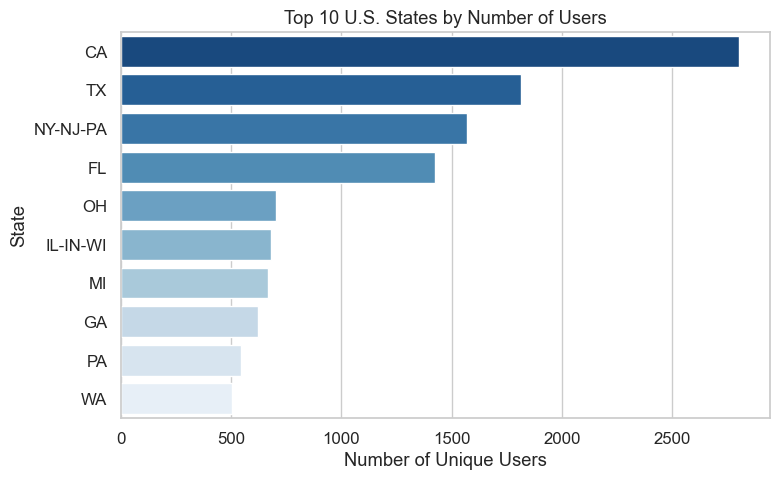

In [33]:
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(8,5))
sns.barplot(data=state_counts.head(10), y="state", x="count", palette="Blues_r")
plt.title("Top 10 U.S. States by Number of Users")
plt.xlabel("Number of Unique Users")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [34]:
churn_by_state = (
    data.filter(F.col("state").isNotNull())
        .select("userId", "state", "churn_flag")
        .distinct()
        .groupBy("state")
        .agg(
            F.count("*").alias("total_users"),
            F.sum("churn_flag").alias("churned_users")
        )
        .withColumn("churn_rate", (F.col("churned_users") / F.col("total_users")) * 100)
        .orderBy(F.desc("churn_rate"))
        .toPandas()
)

churn_by_state.head(10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,state,total_users,churned_users,churn_rate
0,WV-VA,5,3,60.000000
1,IL-MO,4,2,50.000000
2,WY-ID,4,2,50.000000
3,OR-ID,4,2,50.000000
4,TX-AR,12,5,41.666667
5,WI-MI,5,2,40.000000
6,IA-IL-MO,5,2,40.000000
7,VA-WV,8,3,37.500000
8,WV-KY-OH,27,10,37.037037
9,MA-CT,61,22,36.065574


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_94175/1513007063.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


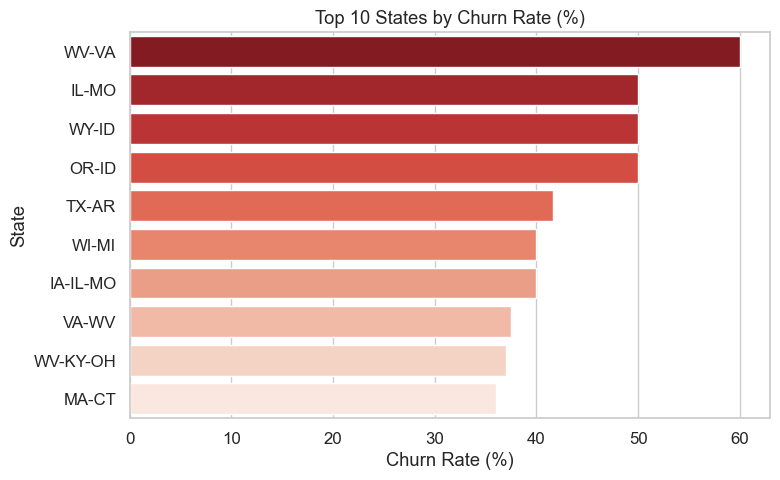

In [35]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=churn_by_state.head(10),
    x="churn_rate", y="state",
    palette="Reds_r"
)
plt.title("Top 10 States by Churn Rate (%)")
plt.xlabel("Churn Rate (%)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [36]:
data.columns

['userId',
 'artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'churn_flag',
 'state',
 'city']

### Insights:
- The majority of users come from large metro states like **CA**, **TX**, **NY**, and **FL**.
- Churn rates vary by region — smaller states often show higher churn percentages due to smaller, less stable user bases.
- These findings can guide **localized marketing campaigns** or **regional retention strategies**.

In [37]:
data.columns

['userId',
 'artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'churn_flag',
 'state',
 'city']

In [38]:
data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data.columns]).show(truncate=False)

+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+
|userId|artist |auth|firstName|gender|itemInSession|lastName|length |level|location|method|page|registration|sessionId|song   |status|ts |userAgent|churn_flag|state |city  |
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+
|0     |5408927|0   |778479   |778479|0            |778479  |5408927|0    |778479  |0     |0   |778479      |0        |5408927|0     |0  |778479   |0         |778479|778479|
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+



Columns like artist, song, and length have missing values — that’s expected (because not all events are songs).
	•	firstName, lastName, gender missing for a few users — normal.
	•	userId, auth, and churn_flag have 0 missing values, which is perfect for modeling.

### 🧹 Data Cleaning — Removing Invalid and Corrupted Records

Before exploring user behavior, it’s essential to ensure that our dataset contains only valid user events.  
During inspection, we identified a few corrupted or meaningless rows — for example, rows where every column contained numeric placeholders (e.g., `5408927`, `778479`), or events not linked to any user (`userId = 0` or `NULL`).  
Such records appear due to data ingestion errors or anonymous system logs and can bias churn metrics.

We apply the following cleaning steps:

| Type of Invalid Row | Description | Action |
|----------------------|-------------|---------|
| **Missing or zero `userId`** | System events or incomplete logs with no identifiable user | 🔴 Drop |
| **Corrupted numeric records** | Rows where text fields (e.g., `artist`, `song`) contain only digits | 🔴 Drop |
| **Missing `page` field** | Indicates an incomplete or malformed event | 🔴 Drop |
| **Expected nulls** (`artist`, `song`, `length`) | Non-song interactions like “Home” or “Login” | 🟢 Keep |

After cleaning, we re-check missing values to confirm that all retained rows represent valid user interactions.  
This ensures that downstream analysis—such as churn flag assignment, engagement metrics, and modeling—is based on complete and consistent user data.

In [41]:
from pyspark.sql import functions as F

# Count users with <3 sessions
low_sessions_count = data.groupBy("userId") \
    .agg(F.countDistinct("sessionId").alias("num_sessions")) \
    .filter(F.col("num_sessions") < 3) \
    .count()

print(f"Number of users with <3 sessions: {low_sessions_count}")

# Count users with no song plays (page != 'NextSong')
no_song_plays_count = data.groupBy("userId") \
    .agg(F.sum((F.col("page") == "NextSong").cast("int")).alias("num_song_plays")) \
    .filter(F.col("num_song_plays") == 0) \
    .count()

print(f"Number of users with no song plays: {no_song_plays_count}")

Number of users with <3 sessions: 2479


Number of users with no song plays: 17


In [42]:
from pyspark.sql import functions as F

# Show users with <3 sessions
low_sessions_users = data.groupBy("userId") \
    .agg(F.countDistinct("sessionId").alias("num_sessions")) \
    .filter(F.col("num_sessions") < 3)

print("Users with <3 sessions:")
low_sessions_users.show(truncate=False)

# Show users with no song plays (page != 'NextSong')
no_song_plays_users = data.groupBy("userId") \
    .agg(F.sum((F.col("page") == "NextSong").cast("int")).alias("num_song_plays")) \
    .filter(F.col("num_song_plays") == 0)

print("Users with no song plays:")
no_song_plays_users.show(truncate=False)

Users with <3 sessions:


+-------+------------+
|userId |num_sessions|
+-------+------------+
|1767872|2           |
|1448529|2           |
|1847096|2           |
|1695825|1           |
|1757186|1           |
|1056951|1           |
|1636727|2           |
|1670607|1           |
|1373558|2           |
|1979361|2           |
|1116337|2           |
|1764732|1           |
|1570348|2           |
|1604179|2           |
|1208847|1           |
|1624587|1           |
|1096593|2           |
|1954413|2           |
|1910209|2           |
|1668741|2           |
+-------+------------+
only showing top 20 rows
Users with no song plays:


+-------+--------------+
|userId |num_song_plays|
+-------+--------------+
|1793623|0             |
|1261737|0             |
|1341146|0             |
|1673981|0             |
|1135477|0             |
|1438489|0             |
|1163202|0             |
|1145574|0             |
|1176703|0             |
|1755851|0             |
|1689121|0             |
|1375496|0             |
|1434698|0             |
|1267517|0             |
|1846408|0             |
|1275139|0             |
|1586608|0             |
+-------+--------------+



In [43]:
data.filter(data.userId == "1261737").show(truncate=False)

+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+
|userId |artist|auth      |firstName|gender|itemInSession|lastName|length|level|location|method|page |registration|sessionId|song|status|ts           |userAgent|churn_flag|state|city|
+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+
|1261737|NULL  |Logged Out|NULL     |NULL  |121          |NULL    |NULL  |free |NULL    |GET   |Home |NULL        |160720   |NULL|200   |1541513014000|NULL     |0         |NULL |NULL|
|1261737|NULL  |Logged Out|NULL     |NULL  |111          |NULL    |NULL  |paid |NULL    |GET   |Home |NULL        |158351   |NULL|200   |1541513015000|NULL     |0         |NULL |NULL|
|1261737|NULL  |Logged Out|NULL     |NULL  |112          |NULL    |NULL  |paid |